# Lab 7 Least-Squares Linear Regression, Logistic Regression



# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LAB_ID = "Lab7_Regression1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LAB_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

In this notebook, we use another popular notation for linear regression,
where instead of $w$, we use $\theta$ for the weights; and instead of $\alpha$, we use $\theta_0$ for the bias term.
$x_0$ is now always 1.

Thus, the hypothesis $h(x) = \theta \cdot x = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$.

To find the value of θ that minimizes the cost function, there is a closed-form
solution—in other words, a mathematical equation that gives the result directly.
This is called the Normal Equation.

<center> $\widehat{\theta} = (X^\mathsf{T}X)^{-1}X^\mathsf{T}y$ </center>

We first generate some linear-looking data to test this Normal Equation.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


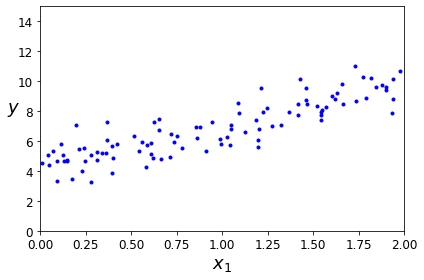

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Now let’s compute $\widehat{\theta}$ using the Normal Equation. We will use the inv()
function from NumPy's linear algebra module (np.linalg) to compute the
inverse of a matrix, and the dot() method for matrix multiplication:

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The function that we used to generate the data is y = 4 + 3x + Gaussian noise.
Let’s see what the equation found:

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_0$ = 4 and $\theta_1$ = 3 instead of $\theta_0$ = 4.215 and $\theta_1$ = 2.770.
Close enough, but the noise made it impossible to recover the exact parameters
of the original function.

Now we can make predictions using $\widehat{\theta}$ :

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions.

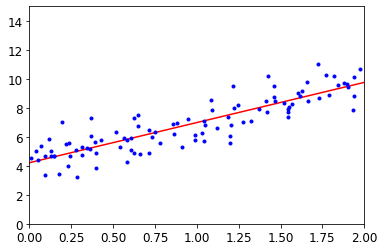

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The figure with a legend and axis labels:

Saving figure linear_model_predictions_plot


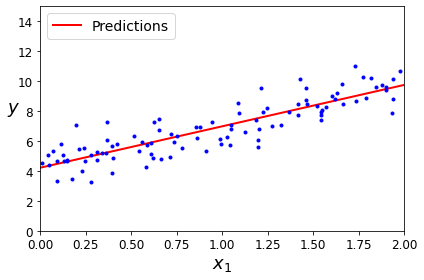

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

Performing Linear Regression using Scikit-Learn is simple:

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# Linear regression using batch gradient descent

To implement Gradient Descent, you need to compute the gradient of the cost
function with regard to each model parameter $\theta$ . In other words, you need to
calculate how much the cost function will change if you change $\theta$ just a little bit.This is called a partial derivative.

You can use the following equation to compute partial derivatives in one go. The gradient vector, noted $\nabla_\theta\mbox{MSE}(\theta)$,
contains all the partial derivatives of the cost function (one for each model
parameter).

<center>$\nabla_\theta\mbox{MSE}(\theta)=\left\{
  \begin{matrix}
    \frac{\partial}{\partial \theta_0}\mbox{MSE}(\theta) \\
    \frac{\partial}{\partial \theta_1}\mbox{MSE}(\theta) \\
    \vdots \\
    \frac{\partial}{\partial \theta_n}\mbox{MSE}(\theta)
  \end{matrix}
  \right\}=\frac{2}{m}X^\mathsf{T}(X\theta-y)$ </center>
  
Once you have the gradient vector, subtracting $\nabla_\theta\mbox{MSE}(\theta)$ from $\theta$.This is
where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to
determine the size of the each step.


Let’s look at a quick implementation of this algorithm:

In [13]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

what if you had used a different learning rate $\eta$? The following Figure shows the first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point).

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


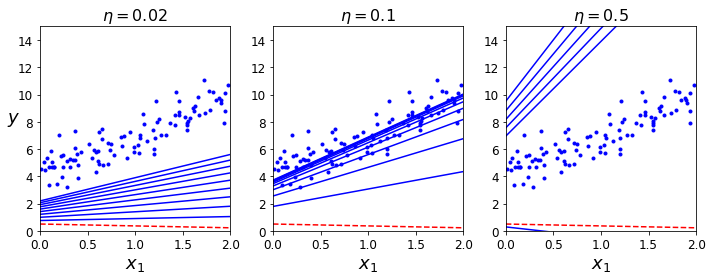

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow
when the training set is large. At the opposite extreme, Stochastic Gradient
Descent picks a random instance in the training set at every step and computes
the gradients based only on that single instance. Obviously, working on a single
instance at a time makes the algorithm much faster because it has very little data
to manipulate at every iteration. It also makes it possible to train on huge
training sets, since only one instance needs to be in memory at each iteration

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is
much less regular than Batch Gradient Descent: instead of gently decreasing
until it reaches the minimum, the cost function will bounce up and down,
decreasing only on average. Over time it will end up very close to the minimum,
but once it gets there it will continue to bounce around, never settling down. 
So once the algorithm stops, the final parameter values are good, but
not optimal.

This code implements Stochastic Gradient Descent using a simple learning
schedule:

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


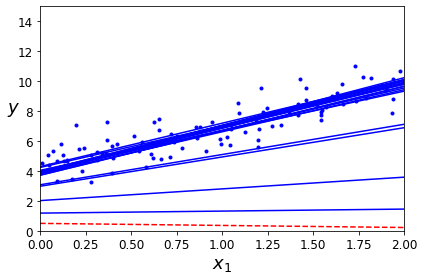

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()                                           

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can
use the SGDRegressor class, which defaults to optimizing the squared error cost
function. The following code runs for maximum 1,000 epochs or until the loss
drops by less than 0.001 during one epoch (max_iter=1000, tol=1e-3). It starts
with a learning rate of 0.1 (eta0=0.1), using the default learning schedule
(different from the preceding one). Lastly, it does not use any regularization
(penalty=None; more details on this shortly):

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# Mini-batch gradient descent

The last Gradient Descent algorithm we will look at is called Mini-batch
Gradient Descent. It is simple to understand once you know Batch and
Stochastic Gradient Descent: at each step, instead of computing the gradients
based on the full training set (as in Batch GD) or based on just one instance (as
in Stochastic GD), Mini-batch GD computes the gradients on small random sets
of instances called mini-batches. The main advantage of Mini-batch GD over
Stochastic GD is that you can get a performance boost from hardware
optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with Stochastic
GD, especially with fairly large mini-batches. As a result, Mini-batch GD will
end up walking around a bit closer to the minimum than Stochastic GD—but it
may be harder for it to escape from local minima (in the case of problems that
suffer from local minima, unlike Linear Regression). The following figure shows the
paths taken by the three Gradient Descent algorithms in parameter space during
training. They all end up near the minimum, but Batch GD’s path actually stops
at the minimum, while both Stochastic GD and Mini-batch GD continue to walk
around. However, don’t forget that Batch GD takes a lot of time to take each
step, and Stochastic GD and Mini-batch GD would also reach the minimum if
you used a good learning schedule.

This code implements Mini-batch Gradient Descent:

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


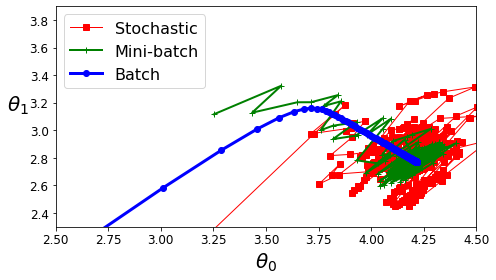

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression

What if your data is more complex than a straight line? Surprisingly, you can use
a linear model to fit nonlinear data. A simple way to do this is to add powers of
each feature as new features, then train a linear model on this extended set of
features. This technique is called Polynomial Regression.

Let’s look at an example. First, let’s generate some nonlinear data, based on a
simple quadratic equation plus some noise.

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


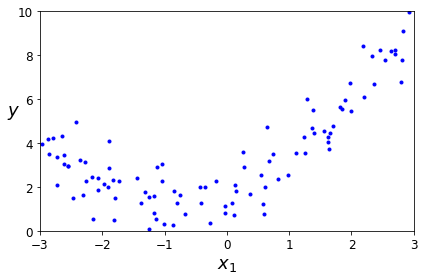

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s
PolynomialFeatures class to transform our training data, adding the square
(second-degree polynomial) of each feature in the training set as a new feature
(in this case there is just one feature):

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly now contains the original feature of X plus the square of this feature.
Now you can fit a LinearRegression model to this extended training data

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


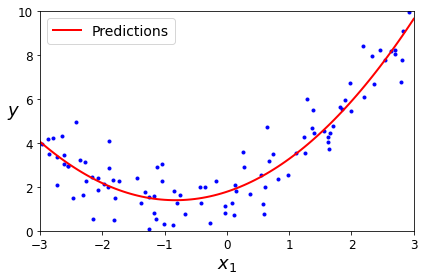

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

If you perform high-degree Polynomial Regression, you will likely fit the
training data much better than with plain Linear Regression. For example,
this figure applies a 300-degree polynomial model to the preceding training
data, and compares the result with a pure linear model and a quadratic model
(second-degree polynomial). Notice how the 300-degree polynomial model
wiggles around to get as close as possible to the training instances.

Saving figure high_degree_polynomials_plot


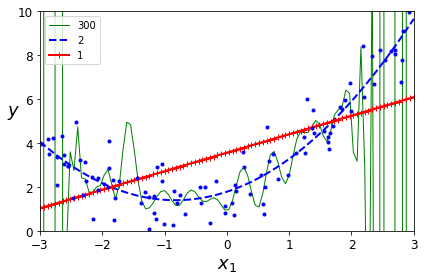

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

This high-degree Polynomial Regression model is severely overfitting the
training data, while the linear model is underfitting it. The model that will
generalize best in this case is the quadratic model, which makes sense because
the data was generated using a quadratic model. But in general you won’t know
what function generated the data, so how can you decide how complex your
model should be? How can you tell that your model is overfitting or underfitting
the data?

You have used cross-validation to get an estimate of a model’s
generalization performance. If a model performs well on the training data but
generalizes poorly according to the cross-validation metrics, then your model is
overfitting. If it performs poorly on both, then it is underfitting. This is one way
to tell when a model is too simple or too complex.

Another way to tell is to look at the learning curves: these are plots of the
model’s performance on the training set and the validation set as a function of
the training set size (or the training iteration). To generate the plots, train the
model several times on different sized subsets of the training set. The following
code defines a function that, given some training data, plots the learning curves
of a model:

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

Saving figure underfitting_learning_curves_plot


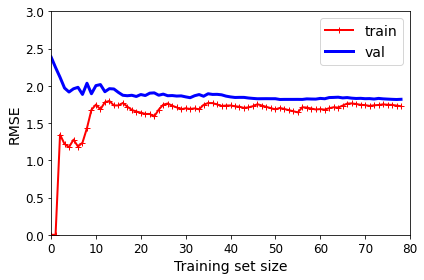

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()                                      

This model that’s underfitting deserves a bit of explanation. First, let’s look at
the performance on the training data: when there are just one or two instances in
the training set, the model can fit them perfectly, which is why the curve starts at
zero. But as new instances are added to the training set, it becomes impossible
for the model to fit the training data perfectly, both because the data is noisy and
because it is not linear at all. So the error on the training data goes up until it
reaches a plateau, at which point adding new instances to the training set doesn’t
make the average error much better or worse. Now let’s look at the performance
of the model on the validation data. When the model is trained on very few
training instances, it is incapable of generalizing properly, which is why the
validation error is initially quite big. Then, as the model is shown more training
examples, it learns, and thus the validation error slowly goes down. However,
once again a straight line cannot do a good job modeling the data, so the error
ends up at a plateau, very close to the other curve.

These learning curves are typical of a model that’s underfitting. Both curves
have reached a plateau; they are close and fairly high.

Now let’s look at the learning curves of a 10th-degree polynomial model on the
same data

Saving figure learning_curves_plot


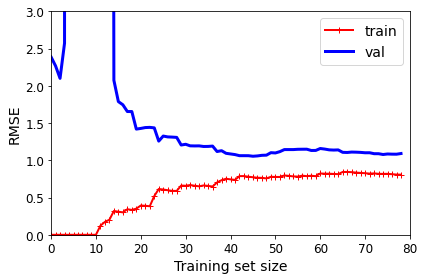

In [37]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

These learning curves look a bit like the previous ones, but there are two very
important differences:

1) The error on the training data is much lower than with the Linear Regression model.

2) There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

# Logistic regression

Logistic Regression (also called Logit Regression)
is commonly used to estimate the probability that an instance belongs to a
particular class (e.g., what is the probability that this email is spam?). If the
estimated probability is greater than 50%, then the model predicts that the
instance belongs to that class (called the positive class, labeled “1”), and
otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled
“0”). This makes it a binary classifier.

A Logistic Regression model computes a weighted sum of the input features (plus
a bias term), but instead of outputting the result directly like the Linear
Regression model does, it outputs the logistic of this result The logistic is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1 shown in the following figure.

Saving figure logistic_function_plot


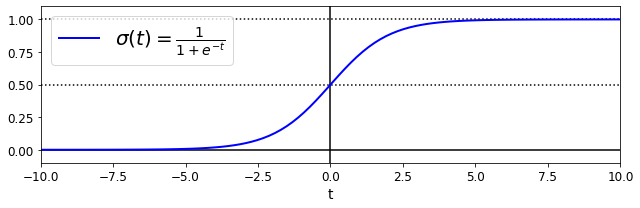

In [38]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

Let’s use the iris dataset to illustrate Logistic Regression. This is a famous
dataset that contains the sepal and petal length and width of 150 iris flowers of
three different species: Iris setosa, Iris versicolor, and Iris virginica.

Let’s try to build a classifier to detect the Iris virginica type based only on the
petal width feature. First let’s load the data:

In [39]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [40]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [41]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

Let’s look at the model’s estimated probabilities for flowers with petal widths
varying from 0 cm to 3 cm

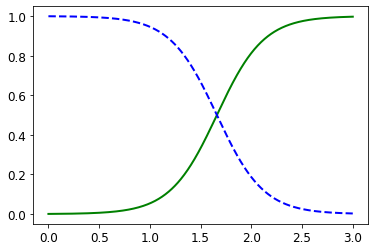

In [43]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

The figure that is a bit fancier:

Saving figure logistic_regression_plot


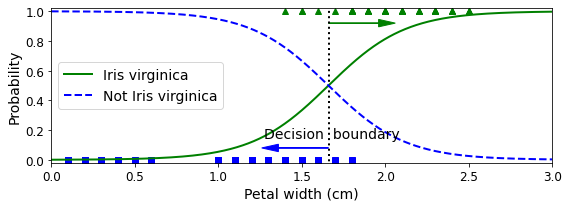

In [44]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

The petal width of Iris virginica flowers (represented by triangles) ranges from
1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally
have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a
bit of overlap. Above about 2 cm the classifier is highly confident that the flower
is an Iris virginica (it outputs a high probability for that class), while below 1 cm
it is highly confident that it is not an Iris virginica (high probability for the “Not
Iris virginica” class). In between these extremes, the classifier is unsure.

In [45]:
decision_boundary

array([1.66066066])

In [46]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

The following Figure shows the same dataset, but this time displaying two features: petal
width and length. Once trained, the Logistic Regression classifier can, based on
these two features, estimate the probability that a new flower is an Iris virginica.
The dashed line represents the points where the model estimates a 50%
probability: this is the model’s decision boundary. Note that it is a linear
boundary. Each parallel line represents the points where the model outputs a
specific probability, from 15% (bottom left) to 90% (top right). All the flowers
beyond the top-right line have an over 90% chance of being Iris virginica,
according to the model.

Saving figure logistic_regression_contour_plot


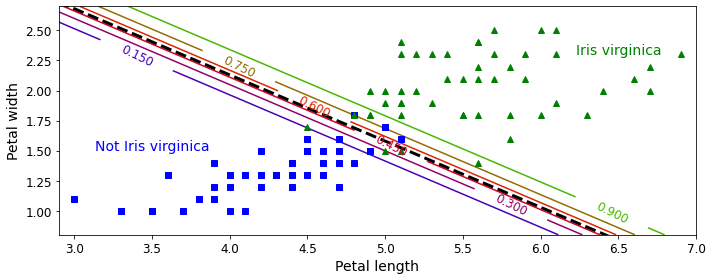

In [47]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

This is the end of Lab 7.